In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import xarray as xr
import random
import os
%load_ext rpy2.ipython


In [2]:
df = pd.read_csv('../results/model/Nested_model/Reduced_Ne_Pi_recomb.csv')

Filter based on callability and remove X chromosome and adjust for missing coverage by extrapolating

In [3]:
df = df[df['freq_mean']>0.7]
df = df[df['chr']!='chrX']
df['corrected_pi'] = df['PI']*df['freq_mean']

# Standardize and center so priors can be mu = 0 and sigma = 1
# This is done by taking the species specific mean 

In [4]:
grouped_df = df.groupby('full_species')


In [5]:
# Step 2: Calculate Mean and Standard Deviation
means = pd.DataFrame()
means[['mean_pi_species','mean_cm_per_mb_species']] = grouped_df[['corrected_pi', 'cm_per_mb']].mean()
means[['sd_pi_species','sd_cm_per_mb_species']] = grouped_df[['corrected_pi', 'cm_per_mb']].std()
means['primate_mean_ne'] = df['NE_MEDIAN'].mean()
means['primate_sd_ne'] = df['NE_MEDIAN'].std()


means = means[['mean_pi_species','mean_cm_per_mb_species', 'sd_pi_species','sd_cm_per_mb_species', 'primate_mean_ne', 'primate_sd_ne']]

In [6]:
# Merge dataframes on the 'full_species' column
merged_df = pd.merge(df, means, on='full_species')

# Reset the index to remove the default index column
merged_df = merged_df.reset_index(drop=True)


In [7]:
merged_df

,Unnamed: 0,genus,species,full_species,MEAN,MEDIAN,NE_MEAN,NE_MEDIAN,freq_mean,cm_per_mb,chr,PI,corrected_pi,mean_pi_species,mean_cm_per_mb_species,sd_pi_species,sd_cm_per_mb_species,primate_mean_ne,primate_sd_ne
0,2,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.809708,0.032423,chr1,0.001810,0.001466,0.001442,1.317787,0.000671,1.566311,70106.64657,64575.160355
1,3,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.716477,1.734505,chr1,0.002047,0.001466,0.001442,1.317787,0.000671,1.566311,70106.64657,64575.160355
2,4,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.784308,1.056430,chr1,0.002565,0.002012,0.001442,1.317787,0.000671,1.566311,70106.64657,64575.160355
3,5,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.747552,0.420616,chr1,0.001845,0.001379,0.001442,1.317787,0.000671,1.566311,70106.64657,64575.160355
4,6,Allenopithecus,nigroviridis,Allenopithecus_nigroviridis,8.357479e-09,8.297569e-09,52454.392022,48795.239046,0.783023,1.470184,chr1,0.001713,0.001342,0.001442,1.317787,0.000671,1.566311,70106.64657,64575.160355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940161,5071719,Varecia,variegata,Varecia_variegata,7.275859e-09,7.124613e-09,71894.996141,65217.078027,0.792828,1.517514,chr9,0.002810,0.002228,0.001676,1.683315,0.000864,1.679226,70106.64657,64575.160355
2940162,5071724,Varecia,variegata,Varecia_variegata,7.275859e-09,7.124613e-09,71894.996141,65217.078027,0.742777,0.186681,chr9,0.002740,0.002035,0.001676,1.683315,0.000864,1.679226,70106.64657,64575.160355
2940163,5071725,Varecia,variegata,Varecia_variegata,7.275859e-09,7.124613e-09,71894.996141,65217.078027,0.774888,0.255109,chr9,0.003150,0.002441,0.001676,1.683315,0.000864,1.679226,70106.64657,64575.160355
2940164,5071773,Varecia,variegata,Varecia_variegata,7.275859e-09,7.124613e-09,71894.996141,65217.078027,0.758048,0.140303,chr9,0.002620,0.001986,0.001676,1.683315,0.000864,1.679226,70106.64657,64575.160355


In [8]:
merged_df['z_pi'] = (merged_df['corrected_pi']-merged_df['mean_pi_species'])/merged_df['sd_pi_species']
merged_df['z_cm_per_mb'] = (merged_df['cm_per_mb']-merged_df['mean_cm_per_mb_species'])/merged_df['sd_cm_per_mb_species']
merged_df['z_ne'] = (merged_df['NE_MEDIAN']-merged_df['primate_mean_ne'])/merged_df['primate_sd_ne']
z_df = merged_df[['full_species','NE_MEDIAN','z_pi', 'z_cm_per_mb', 'z_ne']]

In [9]:
z_df

,full_species,NE_MEDIAN,z_pi,z_cm_per_mb,z_ne
0,Allenopithecus_nigroviridis,48795.239046,0.035514,-0.820631,-0.330025
1,Allenopithecus_nigroviridis,48795.239046,0.036663,0.266051,-0.330025
2,Allenopithecus_nigroviridis,48795.239046,0.849468,-0.166861,-0.330025
3,Allenopithecus_nigroviridis,48795.239046,-0.093303,-0.572792,-0.330025
4,Allenopithecus_nigroviridis,48795.239046,-0.149338,0.097297,-0.330025
...,...,...,...,...,...
2940161,Varecia_variegata,65217.078027,0.638573,-0.098736,-0.075719
2940162,Varecia_variegata,65217.078027,0.415710,-0.891264,-0.075719
2940163,Varecia_variegata,65217.078027,0.885051,-0.850514,-0.075719
2940164,Varecia_variegata,65217.078027,0.358877,-0.918883,-0.075719


In [10]:
unique_Species = z_df['full_species'].unique()
species_lookup = dict(zip(unique_Species, range(len(unique_Species))))
Ne =  (pd.DataFrame([z_df['full_species'], z_df['z_ne']]).transpose()).drop_duplicates()
pi = z_df['z_pi'].values
recombinationrate = z_df['z_cm_per_mb'].values
species = z_df['full_species'].replace(species_lookup).values

# PYMC formulation 

Make variables

In [11]:
hierarchical_model = pm.Model(coords = {"Species": unique_Species, 
                                        "obs_id": np.arange(len(recombinationrate))})
non_centered = True

In [12]:
with hierarchical_model:
# Data
    recomb = pm.ConstantData('recomb', recombinationrate, dims = 'obs_id')
    pi = pm.ConstantData('pi', pi, dims = 'obs_id')
    sp = pm.ConstantData('sp',species, dims = 'obs_id')
    Ne =  pm.ConstantData('Ne', Ne['z_ne'], dims = 'Species')

# Hyperpriors:
    g0 = pm.Normal("g0", mu=0, sigma=1)
    g1 = pm.Normal("g1", mu=0, sigma=1)
    h0 = pm.Normal("h0", mu=0, sigma=1)
    h1 = pm.Normal("h1", mu=0, sigma=1)

    mu_a = g0+g1*Ne
    mu_b = h0+h1*Ne
    sigma_a = pm.Exponential("sigma_a", 1)
    sigma_b = pm.Exponential("sigma_b", 1)
    if non_centered == True:
    # Varying intercepts:
        a_offset = pm.Normal("a_offset", 0, sigma=1, dims="Species")
        a = pm.Deterministic("a", mu_a + a_offset * sigma_a, dims="Species")
        # Varying slopes:
        b_offset = pm.Normal("b_offset", 0, sigma=1, dims="Species")
        b = pm.Deterministic("b", mu_b + b_offset * sigma_b, dims="Species")
# Expected value per species:
    y = a[sp] + b[sp] * recomb
# Model error
    sigma = pm.Exponential("sigma", 0.01)
    Pi = pm.Normal("Pi", mu=y, sigma=sigma, observed=pi, dims="obs_id")

In [13]:
with hierarchical_model:
    idata = pm.sample_prior_predictive(samples=50)

Sampling: [Pi, a_offset, b_offset, g0, g1, h0, h1, sigma, sigma_a, sigma_b]


<Axes: xlabel='Pi / Pi'>

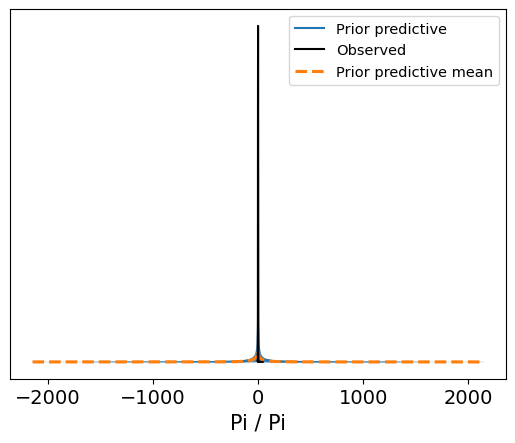

In [14]:
az.plot_ppc(idata, group='prior')

In [ ]:
pm.model_to_graphviz(hierarchical_model)

In [13]:
trace_file = '../results/model/Nested_model/hierarchical_model/hierarchical_model_18_12_2023.nc'
if os.path.exists(trace_file):
    with hierarchical_model:
         hierarchical_model_idata = az.from_netcdf(trace_file)
else:
    with hierarchical_model:
        hierarchical_model_idata = pm.sample(2000, target_accept=0.95, return_inferencedata=True,
                                 progressbar=True, cores=4, chains=4)
        hierarchical_model_idata.to_netcdf(trace_file)

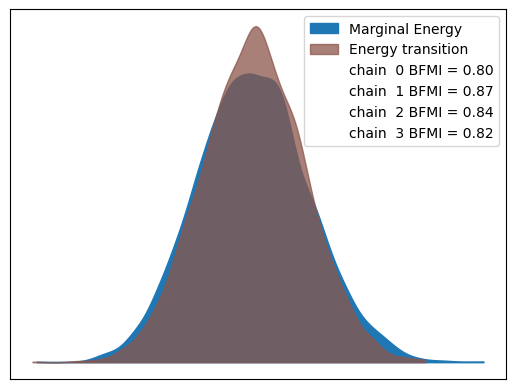

In [22]:
az.plot_energy(hierarchical_model_idata);

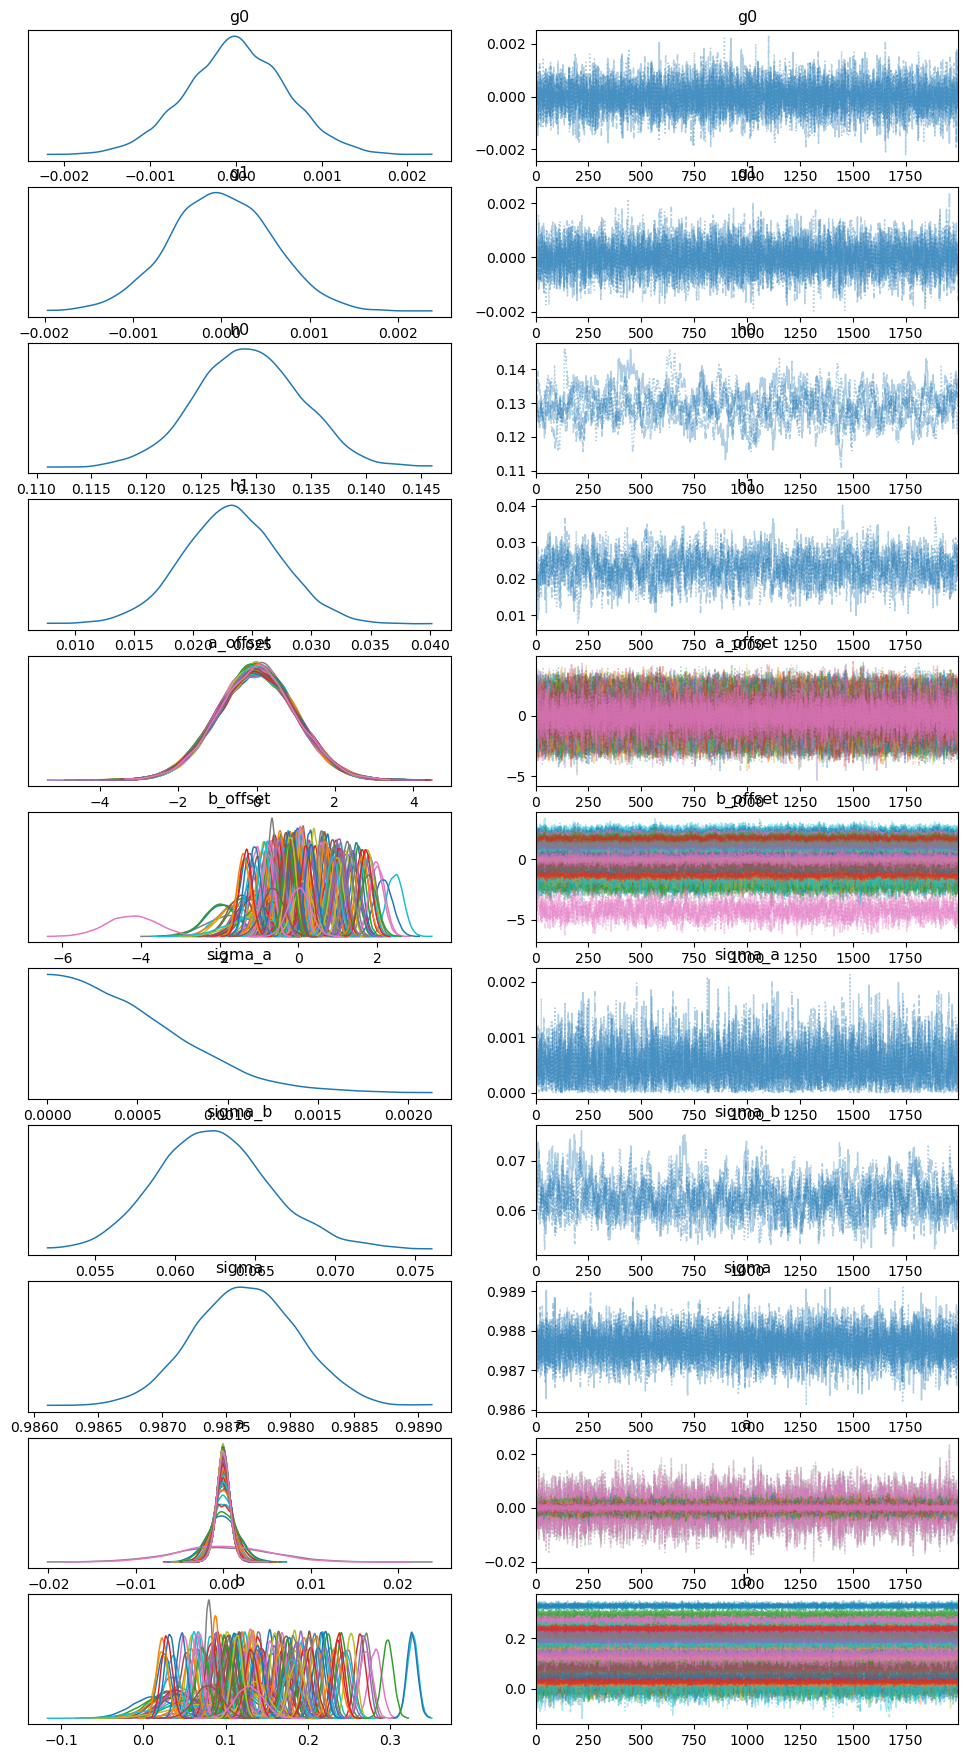

In [24]:
az.plot_trace(hierarchical_model_idata, combined=True);


hierarchical_model = az.from_netcdf('../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/hierarchical_log_scaled_ne_cmpermb_model_18_12_2023.nc')

g0 = hierarchical_model.posterior.g0.to_dataframe()
g0.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/g0_18_12_2023", sep="\t")
g1 = hierarchical_model.posterior.g1.to_dataframe()
g1.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/g1_18_12_2023", sep="\t")
h0 = hierarchical_model.posterior.h0.to_dataframe()
h0.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/h0_18_12_2023", sep="\t")
h1 = hierarchical_model.posterior.h1.to_dataframe()
h1.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/h1_18_12_2023", sep="\t")
sigma_a = hierarchical_model.posterior.sigma_a.to_dataframe()
sigma_a.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_a_18_12_2023", sep="\t")
sigma_b = hierarchical_model.posterior.sigma_b.to_dataframe()
sigma_b.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_b_18_12_2023", sep="\t")
a = hierarchical_model.posterior.a.to_dataframe()
a.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/a_18_12_2023", sep="\t")
b = hierarchical_model.posterior.b.to_dataframe()
b.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/b_18_12_2023", sep="\t")
sgm = hierarchical_model.posterior.sigma.to_dataframe()
sgm.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_model_18_12_2023", sep="\t")

# Log scaled Ne model

In [14]:
#TAKING THE LOG TO BOTH NE AND CM_PER_MB
means_log = pd.DataFrame()
# Step 2: Calculate Mean and Standard Deviation
means_log['mean_pi_species'] = grouped_df['corrected_pi'].mean()
means_log['mean_cm_per_mb_species'] = np.log10(grouped_df['cm_per_mb'].mean())
means_log['sd_pi_species'] = grouped_df['corrected_pi'].std()
means_log['sd_cm_per_mb_species'] = np.log10(grouped_df['cm_per_mb'].std())
means_log['primate_mean_ne'] = np.log10(df['NE_MEDIAN'].mean())
means_log['primate_sd_ne'] = np.log10(df['NE_MEDIAN'].std())


means_log = means_log[['mean_pi_species','mean_cm_per_mb_species', 'sd_pi_species','sd_cm_per_mb_species', 'primate_mean_ne', 'primate_sd_ne']]

In [15]:
# Merge dataframes on the 'full_species' column
merged_log_df = pd.merge(df, means_log, on='full_species')

# Reset the index to remove the default index column
merged_log_df = merged_log_df.reset_index(drop=True).dropna()
#remove real zeros
merged_log_df = merged_log_df[merged_log_df['cm_per_mb']!=0]


In [16]:
merged_log_df['z_pi'] = (merged_log_df['corrected_pi']-merged_log_df['mean_pi_species'])/merged_log_df['sd_pi_species']
merged_log_df['z_cm_per_mb'] = (np.log10(merged_log_df['cm_per_mb'])-merged_log_df['mean_cm_per_mb_species'])/merged_log_df['sd_cm_per_mb_species']
merged_log_df['z_ne'] = (np.log10(merged_log_df['NE_MEDIAN'])-merged_log_df['primate_mean_ne'])/merged_log_df['primate_sd_ne']
z_log_df = merged_log_df[['full_species','NE_MEDIAN','z_pi', 'z_cm_per_mb', 'z_ne']]

In [17]:
z_log_df

,full_species,NE_MEDIAN,z_pi,z_cm_per_mb,z_ne
0,Allenopithecus_nigroviridis,48795.239046,0.035514,-8.256388,-0.032719
1,Allenopithecus_nigroviridis,48795.239046,0.036663,0.612334,-0.032719
2,Allenopithecus_nigroviridis,48795.239046,0.849468,-0.492639,-0.032719
3,Allenopithecus_nigroviridis,48795.239046,-0.093303,-2.544971,-0.032719
4,Allenopithecus_nigroviridis,48795.239046,-0.149338,0.243879,-0.032719
...,...,...,...,...,...
2940161,Varecia_variegata,65217.078027,0.638573,-0.200048,-0.006528
2940162,Varecia_variegata,65217.078027,0.415710,-4.242678,-0.006528
2940163,Varecia_variegata,65217.078027,0.885051,-3.640185,-0.006528
2940164,Varecia_variegata,65217.078027,0.358877,-4.793674,-0.006528


In [18]:
unique_Species_log = z_log_df['full_species'].unique()
species_lookup_log = dict(zip(unique_Species_log, range(len(unique_Species_log))))
Ne_log =  (pd.DataFrame([z_log_df['full_species'], z_log_df['z_ne']]).transpose()).drop_duplicates()
pi_log = z_log_df['z_pi'].values
recombinationrate_log = z_log_df['z_cm_per_mb'].values
species_log = z_log_df['full_species'].replace(species_lookup_log).values


In [19]:
Ne_log 

,full_species,z_ne
0,Allenopithecus_nigroviridis,-0.032719
23342,Allochrocebus_lhoesti,0.015532
46984,Allochrocebus_preussi,0.024187
70575,Allochrocebus_solatus,0.033431
93138,Alouatta_belzebul,-0.022621
...,...,...
2872164,Trachypithecus_melamera,-0.061733
2889185,Trachypithecus_phayrei,-0.107995
2911924,Trachypithecus_pileatus,-0.05385
2933570,Varecia_rubra,-0.045717


In [20]:
hierarchical_log_scaled_ne_cmpermb_model = pm.Model(coords = {"Species": unique_Species_log, 
                                        "obs_id": np.arange(len(recombinationrate_log))})
non_centered = True

In [21]:
with hierarchical_log_scaled_ne_cmpermb_model:
# Data
    recomb = pm.ConstantData('recomb', recombinationrate_log, dims = 'obs_id')
    pi = pm.ConstantData('pi', pi_log, dims = 'obs_id')
    sp = pm.ConstantData('sp',species_log, dims = 'obs_id')
    Ne =  pm.ConstantData('Ne', Ne_log['z_ne'], dims = 'Species')

#Hyperpriors:
    g0 = pm.Normal("g0", mu=0, sigma=1)
    g1 = pm.Normal("g1", mu=0, sigma=1)
    h0 = pm.Normal("h0", mu=0, sigma=1)
    h1 = pm.Normal("h1", mu=0, sigma=1)

    mu_a = g0+g1*Ne
    mu_b = h0+h1*Ne
    sigma_a = pm.Exponential("sigma_a", 1)
    sigma_b = pm.Exponential("sigma_b", 1)
    if non_centered == True:
    # Varying intercepts:
        a_offset = pm.Normal("a_offset", 0, sigma=1, dims="Species")
        a = pm.Deterministic("a", mu_a + a_offset * sigma_a, dims="Species")
        # Varying slopes:
        b_offset = pm.Normal("b_offset", 0, sigma=1, dims="Species")
        b = pm.Deterministic("b", mu_b + b_offset * sigma_b, dims="Species")
# Expected value per species:
    y = a[sp] + b[sp] * recomb
# Model error
    sigma = pm.Exponential("sigma", 0.01)
    Pi = pm.Normal("Pi", mu=y, sigma=sigma, observed=pi, dims="obs_id")


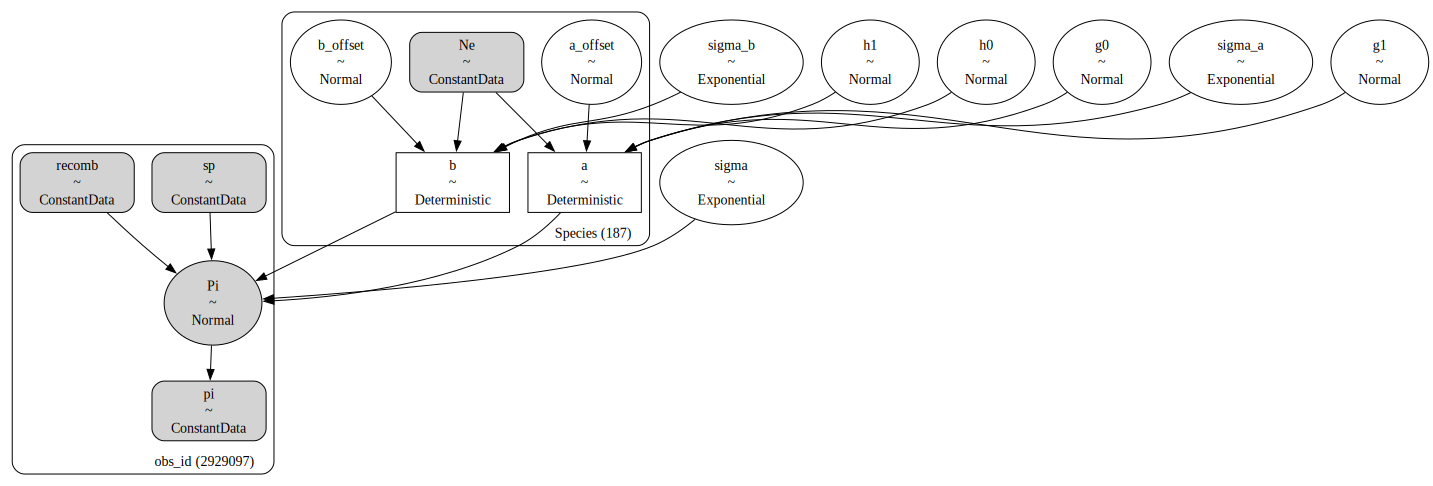

In [40]:
pm.model_to_graphviz(hierarchical_log_scaled_ne_cmpermb_model)

In [104]:
with hierarchical_log_scaled_ne_cmpermb_model:
    idata = pm.sample_prior_predictive(samples=50)

Sampling: [Pi, a_offset, b_offset, g0, g1, h0, h1, sigma, sigma_a, sigma_b]


<Axes: xlabel='Pi / Pi'>

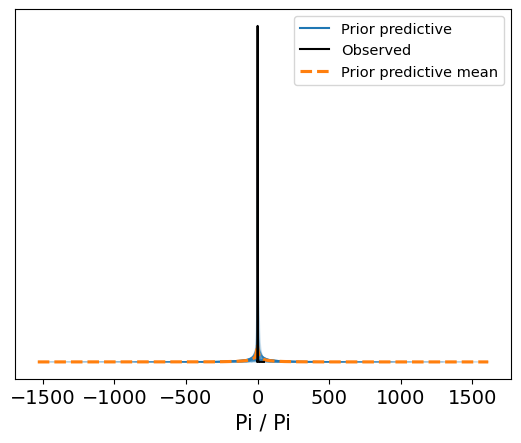

In [105]:
az.plot_ppc(idata, group='prior')

In [22]:
trace_file2 = '../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/hierarchical_log_scaled_ne_cmpermb_model_18_12_2023.nc'
if os.path.exists(trace_file2):
    with hierarchical_log_scaled_ne_cmpermb_model:
         hierarchical_model_log_idata = az.from_netcdf(trace_file2)
else:
    with hierarchical_log_scaled_ne_cmpermb_model:
        hierarchical_model_log_idata = pm.sample(2000, target_accept=0.95, return_inferencedata=True,
                                 progressbar=True, cores=4, chains=4)
        hierarchical_model_log_idata.to_netcdf(trace_file2)

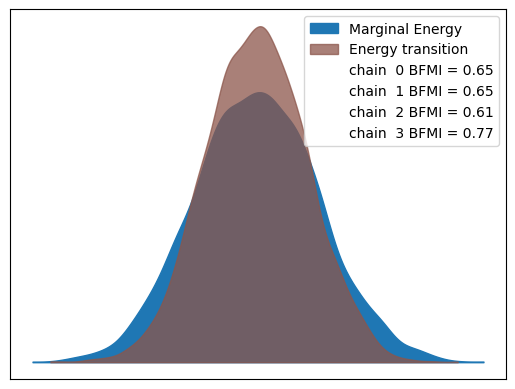

In [25]:
az.plot_energy(hierarchical_model_log_idata);

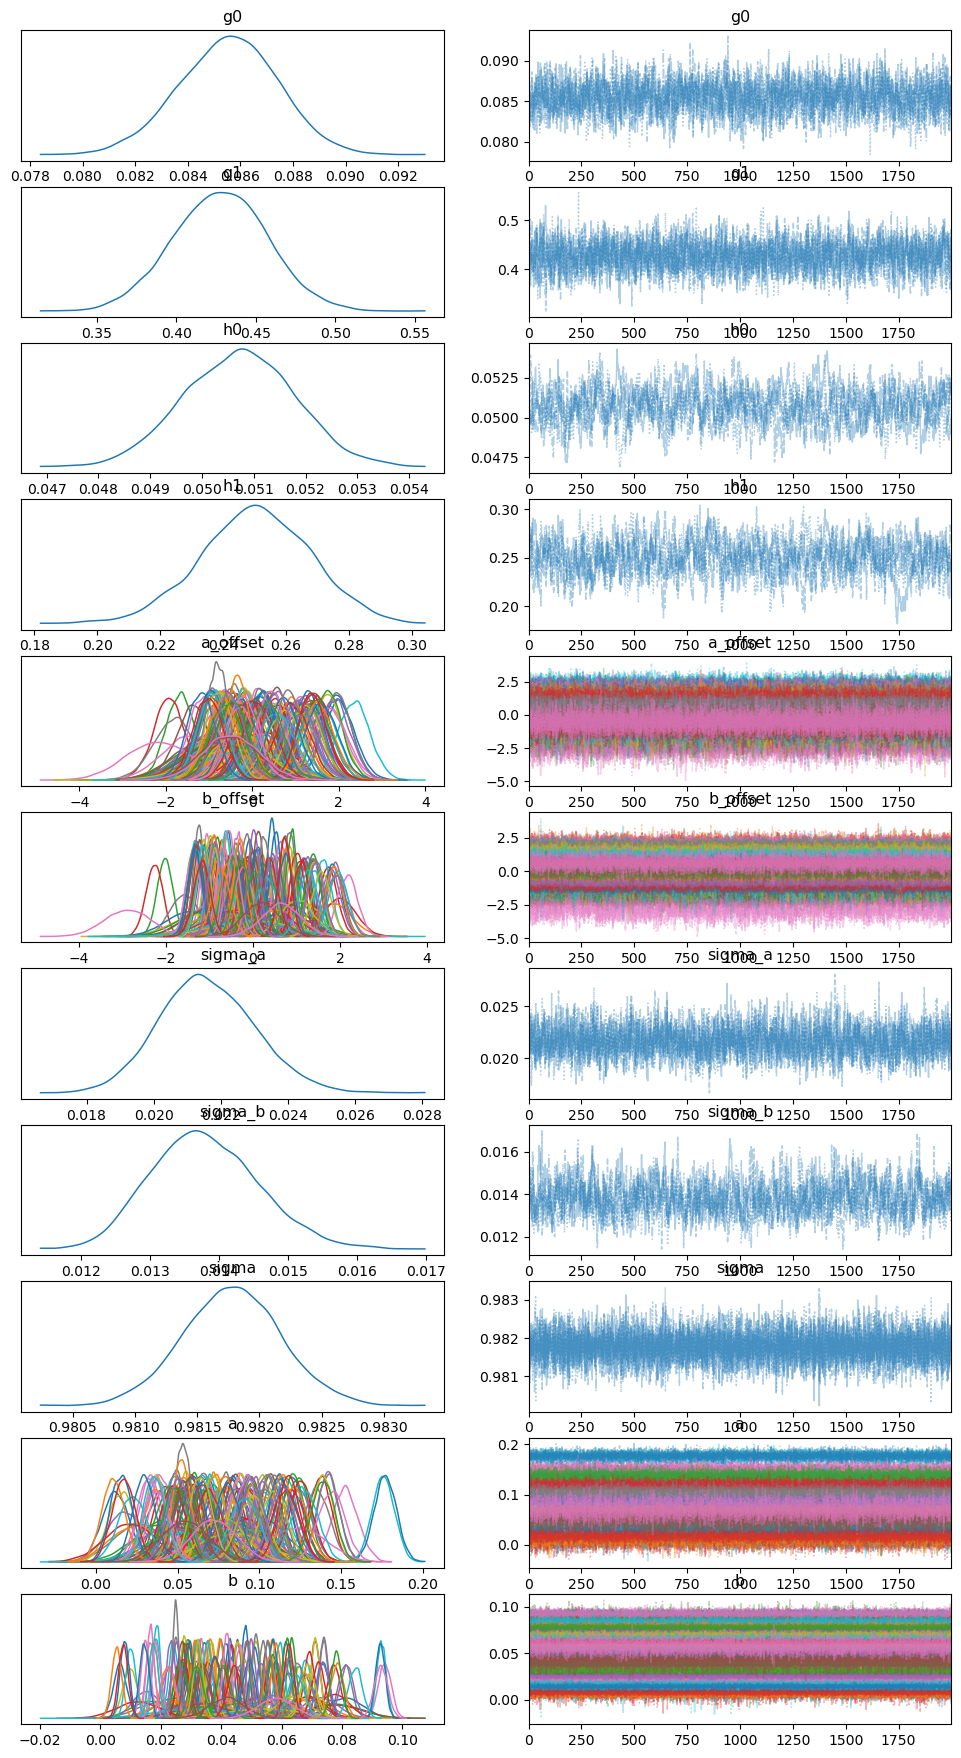

In [26]:
az.plot_trace(hierarchical_model_log_idata, combined=True);

g0 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.g0.to_dataframe()
g0.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/g0_15_12", sep="\t")
g1 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.g1.to_dataframe()
g1.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/g1_15_12_2023", sep="\t")
h0 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.h0.to_dataframe()
h0.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/h0_15_12_2023", sep="\t")
h1 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.h1.to_dataframe()
h1.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/h1_15_12_2023", sep="\t")
sigma_a = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.sigma_a.to_dataframe()
sigma_a.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_a_15_12_2023", sep="\t")
sigma_b = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.sigma_b.to_dataframe()
sigma_b.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_b_15_12_2023", sep="\t")
a = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.a.to_dataframe()
a.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/a_15_12_2023", sep="\t")
b = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.b.to_dataframe()
b.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/b_15_12_2023", sep="\t")
sgm = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.sigma.to_dataframe()
sgm.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_model_15_12_2023", sep="\t")
if non_centered is True:
    b_offset = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.b_offset.to_dataframe()
    b_offset.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/b_offset_15_12_2023", sep="\t")
    a_offset = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.a_offset.to_dataframe()
    a_offset.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/a_offset_15_12_2023", sep="\t")
hierarchical_log_scaled_ne_cmpermb_model_idata.to_netdf('../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/hierarchical_log_scaled_ne_cmpermb_model.nc')

# compare models

In [23]:
with hierarchical_log_scaled_ne_cmpermb_model:
    pm.compute_log_likelihood(hierarchical_model_log_idata)

with hierarchical_model:
    pm.compute_log_likelihood(hierarchical_model_idata)

In [30]:
hierarchical_model.

      g0 ~ Normal(0, 1)
      g1 ~ Normal(0, 1)
      h0 ~ Normal(0, 1)
      h1 ~ Normal(0, 1)
 sigma_a ~ Exponential(f())
 sigma_b ~ Exponential(f())
a_offset ~ Normal(0, 1)
b_offset ~ Normal(0, 1)
   sigma ~ Exponential(f())
       a ~ Deterministic(f(a_offset, sigma_a, g0, g1))
       b ~ Deterministic(f(b_offset, sigma_b, h0, h1))
      Pi ~ Normal(f(a_offset, sigma_a, g0, b_offset, g1, sigma_b, h0, h1), sigma)

In [31]:
hierarchical_log_scaled_ne_cmpermb_model

      g0 ~ Normal(0, 1)
      g1 ~ Normal(0, 1)
      h0 ~ Normal(0, 1)
      h1 ~ Normal(0, 1)
 sigma_a ~ Exponential(f())
 sigma_b ~ Exponential(f())
a_offset ~ Normal(0, 1)
b_offset ~ Normal(0, 1)
   sigma ~ Exponential(f())
       a ~ Deterministic(f(a_offset, sigma_a, g0, g1))
       b ~ Deterministic(f(b_offset, sigma_b, h0, h1))
      Pi ~ Normal(f(a_offset, sigma_a, g0, b_offset, g1, sigma_b, h0, h1), sigma)